In [44]:
from sklearn.datasets import make_multilabel_classification
from torch.utils.data import Dataset
import json
import numpy as np
import torch

In [45]:
# read train data and test data
f_train = open("../data/train.json", 'r')
train_data = json.load(f_train)

f_test = open("../data/test.json", 'r')
test_data = json.load(f_test)

def get_attr_matrix(data):
    n_samples = len(data)
    n_features = 5000 -1 

    # get abstract & title feature
    wmatrix = torch.zeros([n_samples, n_features])

    for i in range(n_samples):
        instance = data[i]
        for title in instance['title']:
            wmatrix[i, title-1] += 1
        for abstract in instance['abstract']:
            wmatrix[i, abstract-1] += 1

    # get venue feature
    vmatrix = torch.zeros([n_samples, 1])

    for i in range(n_samples):
        venue = data[i]['venue']
        
        if venue:
            vmatrix[i, ] = venue
        else:
            vmatrix[i, ] = -1

    # get year feature
    ymatrix = torch.zeros([n_samples, 1])

    for i in range(n_samples):
        year = data[i]['year']
        
        if year:
            ymatrix[i, ] = year
        else:
            ymatrix[i, ] = -1
            
    return torch.cat((wmatrix, vmatrix, ymatrix), 1)

attr_matrix = get_attr_matrix(train_data)
attr_matrix_test = get_attr_matrix(test_data)

def handle_authors(data, key="author"):

    n_samples = len(data)

    # prolific authors 
    y = torch.zeros([n_samples, 100])

    # get co-author matrix
    amatrix = torch.zeros([n_samples, 21245 - 100 + 1])

    for i in range(n_samples):
        authors = data[i][key]
        
        for au in authors:
            if au < 100:
                
                y[i, au] += 1
            else:
                amatrix[i, au - 100] += 1

    return amatrix, y

amatrix, y = handle_authors(train_data, key="authors")

amatrix_test, _ = handle_authors(test_data, key="coauthors")

X = torch.cat((attr_matrix, amatrix), 1)
X_kaggle = torch.cat((attr_matrix_test, amatrix_test), 1)

print("Train:")
print("     X : ", X.shape)
print("     y : ", y.shape)
print("Test_Kaggle:")
print("     X : ", X_kaggle.shape)

Train:
     X :  torch.Size([25793, 26147])
     y :  torch.Size([25793, 100])
Test_Kaggle:
     X :  torch.Size([800, 26147])


In [2]:
def make_dataset():
    x, y = make_multilabel_classification(
        n_samples=10000, n_features=12, n_classes=5, n_labels=2, random_state=1
    )
    # use 9900 samples for training
    x_train = x[:9900]
    y_train = y[:9900]
    # use 100 samples for testing
    x_test = x[-100:]
    y_test = y[-100:]
    return x_train, y_train, x_test, y_test

In [46]:
# `BinaryDataset()` class for multi-head binary classification model
class BinaryDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        features = self.x[index, :]
        labels = self.y[index, :]
        
        # we have 12 feature columns 
        features = torch.tensor(features, dtype=torch.float32)
        # there are 5 classes and each class can have a binary value ...
        # ... either 0 or 1
        label_dict = {'features': features}
        for i in range(100):
            key = 'label' + str(i)
            label_dict[key] = torch.tensor(labels[i], dtype=torch.float32)

        return label_dict
        
            # label1 = torch.tensor(labels[0], dtype=torch.float32)
            # label2 = torch.tensor(labels[1], dtype=torch.float32)
            # label3 = torch.tensor(labels[2], dtype=torch.float32)
            # label4 = torch.tensor(labels[3], dtype=torch.float32)
            # label5 = torch.tensor(labels[4], dtype=torch.float32)
        
        # return {
        #     'features': features,
        #     'label1': label1,
        #     'label2': label2,
        #     'label3': label3,
        #     'label4': label4,
        #     'label5': label5,
        # }

In [4]:
import torch.nn as nn
import torch.nn.functional as F

In [54]:
class MultiHeadBinaryModel(nn.Module):
    def __init__(self):
        super(MultiHeadBinaryModel, self).__init__()
        # self.fc1 = nn.Linear(12, 32) # 12 is the number of features
        # self.fc2 = nn.Linear(32, 64)
        # self.fc3 = nn.Linear(64, 128)
        # self.fc4 = nn.Linear(128, 256)

        self.fc1 = nn.Linear(26147, 26147*2)
        
        # we will treat each head as a binary classifier ...
        # ... so the output features will be 1
        # self.out1 = nn.Linear(256, 1)
        # self.out2 = nn.Linear(256, 1)
        # self.out3 = nn.Linear(256, 1)
        # self.out4 = nn.Linear(256, 1)
        # self.out5 = nn.Linear(256, 1)
        self.out =[]
        for i in range(100):
            self.out[i] = nn.Linear(26147*2, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        # x = F.relu(self.fc4(x))
        
        # each binary classifier head will have its own output
        # out1 = torch.sigmoid(self.out1(x))
        # out2 = torch.sigmoid(self.out2(x))
        # out3 = torch.sigmoid(self.out3(x))
        # out4 = torch.sigmoid(self.out4(x))
        # out5 = torch.sigmoid(self.out5(x))
        
        outs = []

        for i in range(100):
            outs.append(self.out[i](x))        

        return outs

        # return out1, out2, out3, out4, out5

In [55]:
import torch.nn as nn
# custom loss function for multi-head binary classification
# binary_loss_fn
def loss_fn(outputs, targets):
    # o1, o2, o3, o4, o5 = outputs
    # t1, t2, t3, t4, t5 = targets
    # l1 = nn.BCELoss()(o1, t1)
    # l2 = nn.BCELoss()(o2, t2)
    # l3 = nn.BCELoss()(o3, t3)
    # l4 = nn.BCELoss()(o4, t4)
    # l5 = nn.BCELoss()(o5, t5)

    n_class = len(outputs)
    sum_ = 0
    for i in range(n_class):
        sum_ += nn.BCELoss()(torch.reshape(outputs[i], (-1,)), targets[i])

    return sum_ / n_class
    

In [7]:
# from dataset import make_dataset, BinaryDataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

In [8]:
# prepare the dataset
# x_train, y_train, _, _ = make_dataset()
# print some info
print(f"[INFO]: Number of training samples: {X_train.shape[0]}")
print(f"[INFO]: Number of training features: {X_train.shape[1]}")
# train dataset
train_dataset = BinaryDataset(X_train, y_train)
# train data loader
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=1024)
# initialize the model
model = MultiHeadBinaryModel()

[INFO]: Number of training samples: 9900
[INFO]: Number of training features: 12


In [11]:
# n['features']
n

{'features': tensor([5., 4., 1., 6., 3., 1., 3., 9., 3., 1., 9., 2.]),
 'label1': tensor(1.),
 'label2': tensor(1.),
 'label3': tensor(0.),
 'label4': tensor(1.),
 'label5': tensor(1.)}

In [35]:
# training function
def train(model, dataloader, optimizer, loss_fn, train_dataset, device):
    model.train()
    counter = 0
    train_running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_dataset)/dataloader.batch_size)):
        counter += 1
        
        # extract the features and labels
        features = data['features'].to(device)
        target1 = data['label1'].to(device)
        target2 = data['label2'].to(device)
        target3 = data['label3'].to(device)
        target4 = data['label4'].to(device)
        target5 = data['label5'].to(device)
        
        # zero-out the optimizer gradients
        optimizer.zero_grad()
        
        outputs = model(features)
        targets = (target1, target2, target3, target4, target5)
        
        loss = loss_fn(outputs, targets)
        train_running_loss += loss.item()
        
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()
        
    train_loss = train_running_loss / counter
    return train_loss

In [16]:
# learning parameters
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 100
# load the model on to the computation device
model.to(device)

MultiHeadBinaryModel(
  (fc1): Linear(in_features=12, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=256, bias=True)
  (out1): Linear(in_features=256, out_features=1, bias=True)
  (out2): Linear(in_features=256, out_features=1, bias=True)
  (out3): Linear(in_features=256, out_features=1, bias=True)
  (out4): Linear(in_features=256, out_features=1, bias=True)
  (out5): Linear(in_features=256, out_features=1, bias=True)
)

In [40]:
# start the training
train_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, train_dataloader, optimizer, loss_fn, train_dataset, device
    )
    train_loss.append(train_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
torch.save(model.state_dict(), 'outputs/multi_head_binary.pth')

Epoch 1 of 100


10it [00:02,  4.00it/s]                      


Train Loss: 0.2573
Epoch 2 of 100


10it [00:01,  6.46it/s]                      


Train Loss: 0.2561
Epoch 3 of 100


10it [00:01,  6.81it/s]                      


Train Loss: 0.2552
Epoch 4 of 100


10it [00:00, 15.73it/s]                      


Train Loss: 0.2553
Epoch 5 of 100


10it [00:00, 16.81it/s]                      


Train Loss: 0.2558
Epoch 6 of 100


10it [00:00, 14.12it/s]                      


Train Loss: 0.2549
Epoch 7 of 100


10it [00:00, 22.26it/s]                      


Train Loss: 0.2536
Epoch 8 of 100


10it [00:00, 21.06it/s]                      


Train Loss: 0.2539
Epoch 9 of 100


10it [00:00, 17.93it/s]                      


Train Loss: 0.2545
Epoch 10 of 100


10it [00:00, 23.95it/s]                      


Train Loss: 0.2547
Epoch 11 of 100


10it [00:00, 22.37it/s]                      


Train Loss: 0.2539
Epoch 12 of 100


10it [00:00, 17.22it/s]                      


Train Loss: 0.2548
Epoch 13 of 100


10it [00:00, 22.31it/s]                      


Train Loss: 0.2559
Epoch 14 of 100


10it [00:00, 23.35it/s]                      


Train Loss: 0.2553
Epoch 15 of 100


10it [00:00, 18.36it/s]                      


Train Loss: 0.2539
Epoch 16 of 100


10it [00:00, 23.10it/s]                      


Train Loss: 0.2544
Epoch 17 of 100


10it [00:00, 22.76it/s]                      


Train Loss: 0.2535
Epoch 18 of 100


10it [00:00, 24.19it/s]                      


Train Loss: 0.2526
Epoch 19 of 100


10it [00:00, 18.10it/s]                      


Train Loss: 0.2537
Epoch 20 of 100


10it [00:00, 24.30it/s]                      


Train Loss: 0.2518
Epoch 21 of 100


10it [00:00, 24.68it/s]                      


Train Loss: 0.2519
Epoch 22 of 100


10it [00:00, 24.74it/s]                      


Train Loss: 0.2518
Epoch 23 of 100


10it [00:00, 19.72it/s]                      


Train Loss: 0.2509
Epoch 24 of 100


10it [00:00, 23.99it/s]                      


Train Loss: 0.2503
Epoch 25 of 100


10it [00:00, 24.62it/s]                      


Train Loss: 0.2507
Epoch 26 of 100


10it [00:00, 24.80it/s]                      


Train Loss: 0.2503
Epoch 27 of 100


10it [00:00, 19.47it/s]                      


Train Loss: 0.2505
Epoch 28 of 100


10it [00:00, 24.48it/s]                      


Train Loss: 0.2498
Epoch 29 of 100


10it [00:00, 24.30it/s]                      


Train Loss: 0.2491
Epoch 30 of 100


10it [00:00, 19.35it/s]                      


Train Loss: 0.2496
Epoch 31 of 100


10it [00:00, 23.80it/s]                      


Train Loss: 0.2499
Epoch 32 of 100


10it [00:00, 23.90it/s]                      


Train Loss: 0.2486
Epoch 33 of 100


10it [00:00, 24.07it/s]                      


Train Loss: 0.2484
Epoch 34 of 100


10it [00:00, 18.31it/s]                      


Train Loss: 0.2485
Epoch 35 of 100


10it [00:00, 23.82it/s]                      


Train Loss: 0.2514
Epoch 36 of 100


10it [00:00, 19.38it/s]                      


Train Loss: 0.2514
Epoch 37 of 100


10it [00:00, 24.76it/s]                      


Train Loss: 0.2493
Epoch 38 of 100


10it [00:00, 24.35it/s]                      


Train Loss: 0.2476
Epoch 39 of 100


10it [00:00, 24.49it/s]                      


Train Loss: 0.2465
Epoch 40 of 100


10it [00:00, 19.46it/s]                      


Train Loss: 0.2465
Epoch 41 of 100


10it [00:00, 24.04it/s]                      


Train Loss: 0.2475
Epoch 42 of 100


10it [00:00, 19.28it/s]                      


Train Loss: 0.2474
Epoch 43 of 100


10it [00:00, 24.57it/s]                      


Train Loss: 0.2461
Epoch 44 of 100


10it [00:00, 24.54it/s]                      


Train Loss: 0.2457
Epoch 45 of 100


10it [00:00, 24.09it/s]                      


Train Loss: 0.2501
Epoch 46 of 100


10it [00:00, 18.92it/s]                      


Train Loss: 0.2474
Epoch 47 of 100


10it [00:00, 24.45it/s]                      


Train Loss: 0.2452
Epoch 48 of 100


10it [00:00, 18.86it/s]                      


Train Loss: 0.2448
Epoch 49 of 100


10it [00:00, 24.42it/s]                      


Train Loss: 0.2444
Epoch 50 of 100


10it [00:00, 23.78it/s]                      


Train Loss: 0.2453
Epoch 51 of 100


10it [00:00, 24.53it/s]                      


Train Loss: 0.2453
Epoch 52 of 100


10it [00:00, 18.89it/s]                      


Train Loss: 0.2445
Epoch 53 of 100


10it [00:00, 24.55it/s]                      


Train Loss: 0.2430
Epoch 54 of 100


10it [00:00, 24.24it/s]                      


Train Loss: 0.2437
Epoch 55 of 100


10it [00:00, 18.81it/s]                      


Train Loss: 0.2436
Epoch 56 of 100


10it [00:00, 24.62it/s]                      


Train Loss: 0.2426
Epoch 57 of 100


10it [00:00, 23.69it/s]                      


Train Loss: 0.2430
Epoch 58 of 100


10it [00:00, 24.29it/s]                      


Train Loss: 0.2415
Epoch 59 of 100


10it [00:00, 18.80it/s]                      


Train Loss: 0.2412
Epoch 60 of 100


10it [00:00, 23.73it/s]                      


Train Loss: 0.2432
Epoch 61 of 100


10it [00:00, 24.10it/s]                      


Train Loss: 0.2453
Epoch 62 of 100


10it [00:00, 24.28it/s]                      


Train Loss: 0.2412
Epoch 63 of 100


10it [00:00, 18.75it/s]                      


Train Loss: 0.2414
Epoch 64 of 100


10it [00:00, 24.38it/s]                      


Train Loss: 0.2398
Epoch 65 of 100


10it [00:00, 24.29it/s]                      


Train Loss: 0.2418
Epoch 66 of 100


10it [00:00, 24.41it/s]                      


Train Loss: 0.2423
Epoch 67 of 100


10it [00:00, 18.37it/s]                      


Train Loss: 0.2415
Epoch 68 of 100


10it [00:00, 23.41it/s]                      


Train Loss: 0.2407
Epoch 69 of 100


10it [00:00, 24.41it/s]                      


Train Loss: 0.2412
Epoch 70 of 100


10it [00:00, 18.92it/s]                      


Train Loss: 0.2402
Epoch 71 of 100


10it [00:00, 24.41it/s]                      


Train Loss: 0.2405
Epoch 72 of 100


10it [00:00, 24.23it/s]                      


Train Loss: 0.2420
Epoch 73 of 100


10it [00:00, 24.26it/s]                      


Train Loss: 0.2401
Epoch 74 of 100


10it [00:00, 18.85it/s]                      


Train Loss: 0.2385
Epoch 75 of 100


10it [00:00, 24.45it/s]                      


Train Loss: 0.2391
Epoch 76 of 100


10it [00:00, 18.85it/s]                      


Train Loss: 0.2437
Epoch 77 of 100


10it [00:00, 24.02it/s]                      


Train Loss: 0.2389
Epoch 78 of 100


10it [00:00, 24.55it/s]                      


Train Loss: 0.2375
Epoch 79 of 100


10it [00:00, 21.94it/s]                      


Train Loss: 0.2362
Epoch 80 of 100


10it [00:00, 18.86it/s]                      


Train Loss: 0.2376
Epoch 81 of 100


10it [00:00, 24.40it/s]                      


Train Loss: 0.2368
Epoch 82 of 100


10it [00:00, 19.34it/s]                      


Train Loss: 0.2356
Epoch 83 of 100


10it [00:00, 24.37it/s]                      


Train Loss: 0.2348
Epoch 84 of 100


10it [00:00, 24.21it/s]                      


Train Loss: 0.2365
Epoch 85 of 100


10it [00:00, 24.43it/s]                      


Train Loss: 0.2365
Epoch 86 of 100


10it [00:00, 19.16it/s]                      


Train Loss: 0.2350
Epoch 87 of 100


10it [00:00, 24.60it/s]                      


Train Loss: 0.2368
Epoch 88 of 100


10it [00:00, 19.29it/s]                      


Train Loss: 0.2363
Epoch 89 of 100


10it [00:00, 24.42it/s]                      


Train Loss: 0.2345
Epoch 90 of 100


10it [00:00, 24.11it/s]                      


Train Loss: 0.2336
Epoch 91 of 100


10it [00:00, 24.41it/s]                      


Train Loss: 0.2334
Epoch 92 of 100


10it [00:00, 19.64it/s]                      


Train Loss: 0.2331
Epoch 93 of 100


10it [00:00, 24.39it/s]                      


Train Loss: 0.2332
Epoch 94 of 100


10it [00:00, 24.25it/s]                      


Train Loss: 0.2319
Epoch 95 of 100


10it [00:00, 19.49it/s]                      


Train Loss: 0.2329
Epoch 96 of 100


10it [00:00, 24.11it/s]                      


Train Loss: 0.2318
Epoch 97 of 100


10it [00:00, 24.65it/s]                      


Train Loss: 0.2305
Epoch 98 of 100


10it [00:00, 24.09it/s]                      


Train Loss: 0.2315
Epoch 99 of 100


10it [00:00, 17.55it/s]                      


Train Loss: 0.2306
Epoch 100 of 100


10it [00:00, 24.64it/s]                      

Train Loss: 0.2317


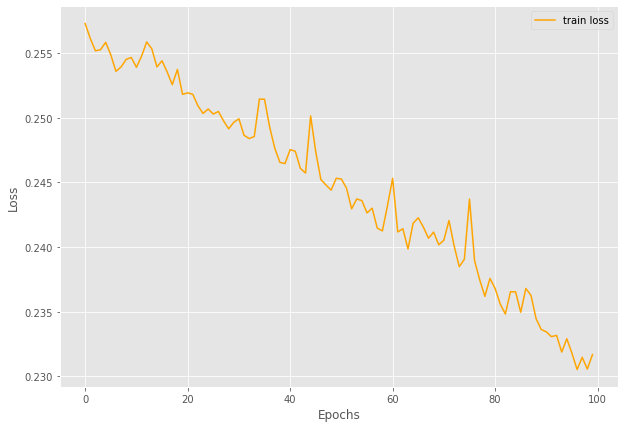

In [41]:
# plot and save the train loss graph
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('outputs/multi_head_binary_loss.png')
plt.show()